### Configure the Spark Context

In [1]:
def setupSpark():
  # Spark needs to run with Java 8 ... 
  !pip install -q findspark
  !apt-get install openjdk-8-jdk-headless > /dev/null
  !echo 2 | update-alternatives --config java > /dev/null
  !wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
  !tar xf spark-3.1.2-bin-hadoop3.2.tgz
  # !java -version
  import os, findspark
  os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
  os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
  # !echo JAVA_HOME=$JAVA_HOME
  !pip install -q pyspark
  findspark.init()
  !pyspark --version


setupSpark()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.1.2
      /_/
                        
Using Scala version 2.12.10, OpenJDK 64-Bit Server VM, 1.8.0_362
Branch HEAD
Compiled by user centos on 2021-05-24T04:27:48Z
Revision de351e30a90dd988b133b3d00fa6218bfcaba8b8
Url https://github.com/apache/spark
Type --help for more information.


In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
    
spark = SparkSession\
        .builder\
        .master('local[*]')\
        .getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("WARN")

## Read in Dataset

In [3]:
from pyspark.sql.functions import *

In [5]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
filePath = "drive/MyDrive/Colab Notebooks/comments.parquet"
comments_df = spark.read.format("parquet").option("header","true").load(filePath)


In [7]:
## push comments to textfile
comments = comments_df.toPandas()
comments["comment_text"].to_csv('drive/MyDrive/Colab Notebooks/comments.txt', sep="\n", index=False)

In [8]:
comments_df.printSchema()

root
 |-- username_href: string (nullable = true)
 |-- view_key: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- upvotes: long (nullable = true)
 |-- timestamp: integer (nullable = true)



In [9]:
## upvotes is a string, we want it to be an int
comments_df = comments_df.withColumn('upvotes', col('upvotes').cast('int'))

In [10]:
comments_df.printSchema()

root
 |-- username_href: string (nullable = true)
 |-- view_key: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- upvotes: integer (nullable = true)
 |-- timestamp: integer (nullable = true)



## Exploratory Data Analysis

### Average Upvote Number

In [11]:
import pandas as pd
import pyspark as ps

In [12]:
## mode of upvotes
comments_df.groupby("upvotes").count().orderBy("count", ascending=False).show()

+-------+------+
|upvotes| count|
+-------+------+
|      0|325964|
|      1|169063|
|      2| 80630|
|      3| 48900|
|      4| 32883|
|      5| 23772|
|      6| 18335|
|      7| 14075|
|      8| 11574|
|      9|  9424|
|     10|  7775|
|     11|  6605|
|     12|  5685|
|     13|  4943|
|     14|  4513|
|     15|  3980|
|     16|  3645|
|     17|  3263|
|     18|  3060|
|     19|  2633|
+-------+------+
only showing top 20 rows



In [13]:
# avg of upvotes
comments_df.select(mean('upvotes')).collect()

[Row(avg(upvotes)=8.573588775718045)]

### Unique Comments

In [14]:
comments_df.select('comment_text').distinct().count()

716120

## Word Frequency

In [15]:
data_file = 'drive/MyDrive/Colab Notebooks/comments.txt'
# take file and distribute it across worker nodes
comments_rdd = sc.textFile(data_file)

In [16]:
comments_rdd.take(20)

['comment_text',
 'Old video...come on pornhub...you can do better than this',
 'Wow 😍',
 'Does anyone know what is the IG account from this channel ?',
 'Clickbait in porn... I just totally lost my faith in humanity.',
 'I would definitely suck a fart out of your asshole!',
 'Super hot, why lie',
 'big toys are fine, but you make me die when you stick your fingers in the A-hole. oh fuck i cummed',
 "This is great. I can't relax in front of the camera like that",
 '❤',
 'love',
 'просто классная девчонка 😍',
 'I’m obsessed!! Your content is amazing 🤫',
 'Amazing content OMG 🔥😍',
 'i love being a lesbian',
 'me too',
 'Better without music.',
 'perfect vid!',
 'Spreads legs love it',
 'Yummy!!!!']

In [17]:
def clean_text(x):
  punc = '!"#$&\'()*+,.:;<=>?@[\\]^_`{|}~-'
  lowercased_str = x.lower()
  for ch in punc:
    lowercased_str = lowercased_str.replace(ch, '')
  return lowercased_str

In [18]:
comments_rdd = comments_rdd.map(clean_text)

In [19]:
comments_rdd.take(20)

['commenttext',
 'old videocome on pornhubyou can do better than this',
 'wow 😍',
 'does anyone know what is the ig account from this channel ',
 'clickbait in porn i just totally lost my faith in humanity',
 'i would definitely suck a fart out of your asshole',
 'super hot why lie',
 'big toys are fine but you make me die when you stick your fingers in the ahole oh fuck i cummed',
 'this is great i cant relax in front of the camera like that',
 '❤',
 'love',
 'просто классная девчонка 😍',
 'i’m obsessed your content is amazing 🤫',
 'amazing content omg 🔥😍',
 'i love being a lesbian',
 'me too',
 'better without music',
 'perfect vid',
 'spreads legs love it',
 'yummy']

In [20]:
# split sentence into word list
comments_rdd = comments_rdd.flatMap(lambda x: x.split(" "))

In [21]:
comments_rdd.take(20)

['commenttext',
 'old',
 'videocome',
 'on',
 'pornhubyou',
 'can',
 'do',
 'better',
 'than',
 'this',
 'wow',
 '😍',
 'does',
 'anyone',
 'know',
 'what',
 'is',
 'the',
 'ig',
 'account']

In [22]:
# exlude any whitespaces
comments_rdd = comments_rdd.filter(lambda x: x != '')

In [23]:
comments_rdd.take(20)

['commenttext',
 'old',
 'videocome',
 'on',
 'pornhubyou',
 'can',
 'do',
 'better',
 'than',
 'this',
 'wow',
 '😍',
 'does',
 'anyone',
 'know',
 'what',
 'is',
 'the',
 'ig',
 'account']

In [24]:
## count
comments_count = comments_rdd.map(lambda word:(word,1))
comments_count.take(5)

[('commenttext', 1),
 ('old', 1),
 ('videocome', 1),
 ('on', 1),
 ('pornhubyou', 1)]

In [25]:
# reduce by key
comments_rbk = comments_count.reduceByKey(lambda x, y:(x+y)).sortByKey()
comments_rbk.take(20)

[('\x100', 1),
 ('\x1cgoogle', 1),
 ('%', 27),
 ('%%', 1),
 ('%100', 4),
 ('%15', 1),
 ('%50', 1),
 ('%90', 1),
 ('%appdata%', 7),
 ('%e6%9e%83%e7%80%9b%e6%a5%8b%e7%b4%99%e9%97%88%e5%ad%a6%e7%94%9f%ef%bc%8c%e7%a9%ba%e5%a7%90%e3%80%81%e6%a8%a1%e7%89%b9%e3%80%81%e5%a4%96%ef%bc%88%e7%88%9c%e9%8a%86%e5%82%9d%ef%bc%89%e5%9b%b4%ef%bc%88%e7%88%9c%e9%8a%86%e5%82%9d%ef%bc%89%e5%a5%b3%ef%bc%88%e6%b6%93%e5%93%84%ef%bc%89%e9%a2%84%ef%bc%8c%e7%ba%a6%ef%bc%8c%e7%bd%91%ef%bc%8c%e7%ab%99%ef%bc%9al%20%20%20x%20%20%20s%20%20w%202020%20%ef%bc%88%e7%82%b9%ef%bc%89c%ef%bc%8co%ef%bc%8cm%20%e5%8b%92%20%20%e4%ba%ab%20%e5%95%86%20%e5%8a%a1',
  1),
 ('%e7%b6%8b%e6%9d%88%e6%92%b3%e5%8f%86%e7%bb%be%ee%88%9d%e5%ab%b3%e9%8f%82%e5%ad%a6%e7%94%9f%ef%bc%8c%e7%a9%ba%e5%a7%90%e3%80%81%e6%a8%a1%e7%89%b9%e3%80%81%e5%a4%96%ef%bc%88%e9%97%88%ef%bc%89%e5%9b%b4%ef%bc%88%e9%97%88%ef%bc%89%e5%a5%b3%ef%bc%88%e9%97%88%ef%bc%89%e9%a2%84%ef%bc%8c%e7%ba%a6%ef%bc%8c%e7%bd%91%ef%bc%8c%e7%ab%99%ef%bc%9al%20%20%20x%20%20%20s%20%20w%2020

In [26]:
# rank words in descending order
comments_rbk = comments_rbk.map(lambda x: (x[1],x[0]))
comments_rbk.take(5)

[(1, '\x100'), (1, '\x1cgoogle'), (27, '%'), (1, '%%'), (4, '%100')]

In [27]:
comments_rbk.sortByKey(False).take(20)

[(205351, 'i'),
 (184287, 'the'),
 (145157, 'a'),
 (144368, 'to'),
 (131393, 'you'),
 (124149, 'is'),
 (118855, 'and'),
 (92022, 'this'),
 (87514, 'that'),
 (86935, 'so'),
 (85108, 'her'),
 (79293, 'love'),
 (78231, 'my'),
 (70219, 'of'),
 (69032, 'in'),
 (68067, 'she'),
 (66573, 'it'),
 (65893, 'me'),
 (63702, 'hot'),
 (62171, 'like')]

In [28]:
# now, remove stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english') + ['00000000', '000000']

In [30]:
comments_rbk = comments_rbk.filter(lambda x: x[1] not in stopwords).sortByKey(False)
comments_rbk.sortByKey(False).take(20)

[(79293, 'love'),
 (63702, 'hot'),
 (62171, 'like'),
 (47162, 'video'),
 (36415, 'fuck'),
 (33582, 'would'),
 (32830, 'pussy'),
 (32715, 'sexy'),
 (29521, 'girl'),
 (28740, 'nice'),
 (28257, 'ass'),
 (25970, 'want'),
 (25402, 'name'),
 (25025, 'good'),
 (24455, 'beautiful'),
 (23632, 'one'),
 (23558, 'cock'),
 (23092, 'fucking'),
 (22755, 'great'),
 (22099, 'amazing')]

In [31]:
# now, plot
top_20_words = comments_rbk.sortByKey(False).take(20)

In [32]:
# create dictionary from list
indexes = [i for i in range(20)][::-1]
labels = [i[1] for i in top_20_words][::-1]
values = [i[0] for i in top_20_words][::-1]

In [33]:
import matplotlib.pyplot as plt

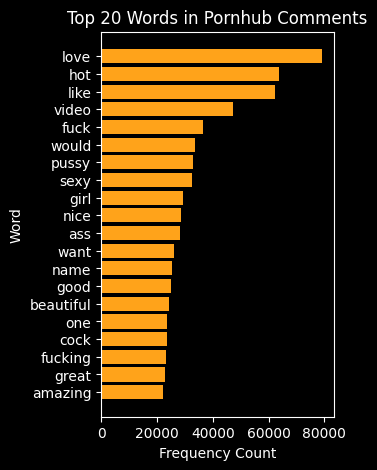

In [48]:
bar_width = 0.35

bar_width = 0.35

fig = plt.figure() 
fig.set_size_inches(3,5)

plt.style.use('dark_background')
plt.barh(indexes, values, color='#ffa31a')

# add labels
plt.yticks(indexes, labels, fontsize=10, color='white')
plt.xlabel('Frequency Count', fontsize=10, color='white')
plt.ylabel('Word', fontsize=10)
plt.title('Top 20 Words in Pornhub Comments', fontsize=12, color='white')
plt.gca().invert_yaxis()
plt.show()

In [35]:
# now, plot wordclouds
top_50_words = comments_rbk.sortByKey(False).take(50)

In [36]:
words = {
    i[1]: i[0] for i in top_50_words
}

In [37]:
words

{'love': 79293,
 'hot': 63702,
 'like': 62171,
 'video': 47162,
 'fuck': 36415,
 'would': 33582,
 'pussy': 32830,
 'sexy': 32715,
 'girl': 29521,
 'nice': 28740,
 'ass': 28257,
 'want': 25970,
 'name': 25402,
 'good': 25025,
 'beautiful': 24455,
 'one': 23632,
 'cock': 23558,
 'fucking': 23092,
 'great': 22755,
 'amazing': 22099,
 'cum': 21792,
 'see': 19478,
 'get': 19349,
 'im': 18947,
 'videos': 18848,
 'dick': 18394,
 'wow': 17731,
 'please': 16840,
 '🙂': 16519,
 'perfect': 15978,
 'really': 15609,
 'shes': 15290,
 'damn': 14946,
 'know': 14819,
 'best': 14816,
 'thank': 14672,
 '😉': 14549,
 'need': 14058,
 'make': 13636,
 'guy': 13390,
 'porn': 13327,
 'much': 12919,
 'wish': 12776,
 'thanks': 12705,
 'guys': 12382,
 'body': 12183,
 'hard': 12181,
 'big': 12076,
 'got': 11893,
 'time': 11775}

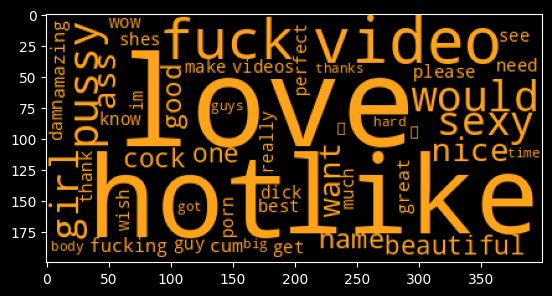

In [38]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import ChainMap
import pyspark.sql.functions as F

wordcloud = WordCloud(background_color="black",  color_func=lambda *args, **kwargs: "#ffa31a")

plt.imshow(wordcloud.generate_from_frequencies(words))

plt.show()

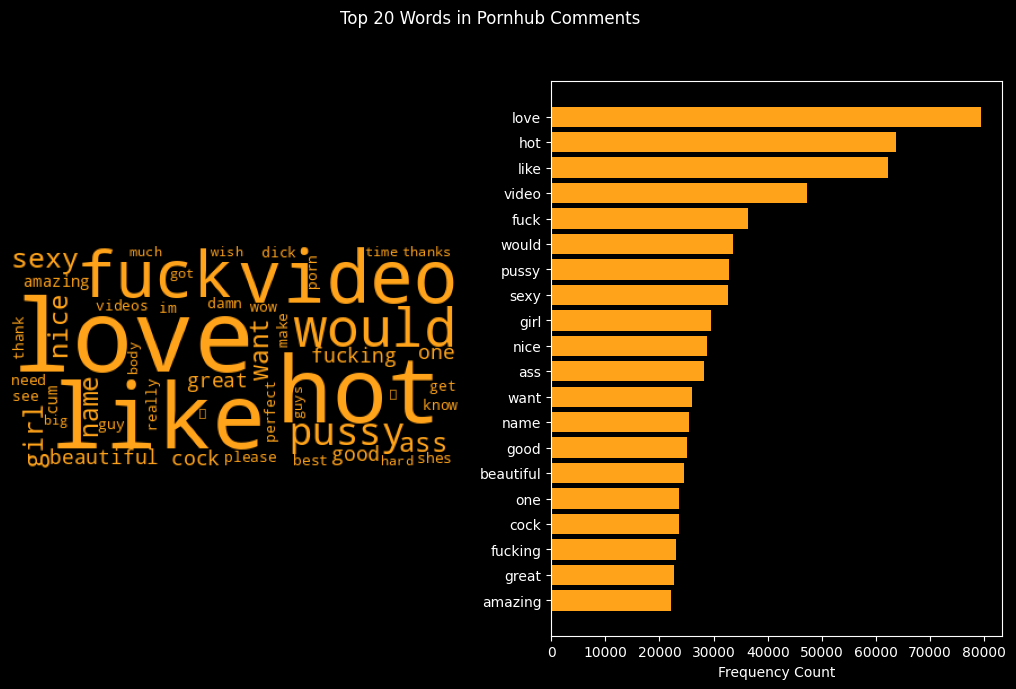

In [49]:
# Wordcloud and frequencies in one plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*6.4, 1.5*4.8))
fig.suptitle('Top 20 Words in Pornhub Comments', fontsize=12, color='white')

plt.style.use('dark_background')
ax1.imshow(wordcloud.generate_from_frequencies(words))
ax1.axis("off")
ax2.barh(indexes, values, color='#ffa31a')

# add labels
ax2.set_yticks(indexes, labels, fontsize=10, color='white')
ax2.set_xlabel('Frequency Count', fontsize=10, color='white')
ax2.invert_yaxis()

fig.savefig('./top_20_and_wordcloud.png', dpi=300)